# Introduction



In this notebook, the enriched data from the NLP classifier is used for a space embeddings model, where the goal is to provide a embedding vector for each grid cell. The embedding vectors are obtained from a shallow, one-layer neural network with multiple output layers. First, this architecture is described thoroughly, whereafter two approaches for the neural network is considered. Finally, a comparison between the two approaches is conducted, where the better performing model is identified to be used in the recommender system. 

## Table of Contents

* [Space Embeddings Model](#0-bullet)
* [Continuous features](#1-bullet)
* [Discrete/categorical features](#2-bullet)
* [Model comparison (Continuous vs Discrete/Categorical)](#3-bullet)
* [Conclusion](#4-bullet)

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.keras.utils import set_random_seed
#set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

The space embeddings dataframe, that was created in [Descriptive Statistics](./DescriptiveStatistics.ipynb) and enriched through [NLP Classification](./NLPClassification.ipynb), is loaded and split into ***X*** and ***y*** matrices used as inputs for our neural network. Normally, one would use the features to predict a target in a machine learning, but it will be done oppositely when trying to learn embeddings for a target or in our case a grid cell. 

Therefore, ***X*** simply contains a one-hot encoding of all the grid cells, which makes it a 480x480 diagonal matrix with ones. The ***y*** matrix contains the features from the space embeddings dataframe and is shown below.

In [12]:
# Load space embeddings data and prepare X and y matrices
df = pd.read_csv("data/space_embedding_data_NLP.csv", index_col=[0])
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

print("Targets (y) shape:", y.shape)
print("Input (X) shape:", X.shape)
y.head()

Targets (y) shape: (480, 21)
Input (X) shape: (480, 480)


,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,Health,...,Outdoors,Restaurant,Retail,Service,Wholesale,ReviewCount,Rating,PositiveReviews,NegativeReviews,ReviewLength
0,8,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,1.0,0.0,125,3.968571,0.696000,0.304000,0.536595
1,10,0,6,1,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,2.0,1.0,31,4.592593,0.851852,0.148148,0.802238
2,3,0,2,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,8,4.200000,0.857143,0.142857,0.999095
3,74,3,32,17,12.0,6.0,6.0,0.0,1.0,4.0,...,0.0,17.0,4.0,7.0,1.0,853,3.694524,0.732975,0.267025,0.895548
4,163,8,78,25,21.0,19.0,20.0,1.0,1.0,10.0,...,0.0,37.0,21.0,9.0,5.0,1330,3.719004,0.801535,0.198465,0.843739


It is chosen to scale the targets in order for them to be weighted as equal as possible in the loss function.

In [13]:
# Standard scaling of targets/features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model <a class="anchor" id="0-bullet"></a>

Now that the data for the space embeddings model has been prepared, it is time to get a better understanding of the space embeddings model. The model is a shallow neural network illustrated by a simplified drawing below:

![NN architecture](img/NN_Architecture.png)

It is seen that the model takes an input of shape (, 480), which is equal to the number of grid cells in our dataset, and feeds it to an embedding layer, which outputs embeddings of shape (, 480, *n*). The *n* refers to the length of the embedding vector, which will be found through hyperparameter tuning, but it is essential that $n<m$ where *m* is the number of features per grid cell, since we are trying to map high-dimensional data to a lower dimension. The embeddings are then flattened and fed into *m* output layers, which will output a single prediction for each feature. Thus, the neural network has *m* losses where the hyperparameter tuning will optimize the aggregation of these *m* losses.

The illustration above considers a regression task with continuous parameters and one output per feature, which will be one of two approaches conducted in this notebook:
1. A neural network with continuous targets and regression metrics
2. A neural network with uniform categorical targets and classification metrics

The first approach requires no data processing and is relatively easy to implement given the nature of the data and the architecture of such a neural network. The idea for the second approach came from a discussion with our mentor, who has had success with using categorical data where the classes are uniformly distributed. This approach will require the final output layers to be categorical where ambiguity can arise regarding the architecture.

Due to the many similarities between the two approaches, the first approach will be described more thoroughly where only differences will be highlighted in the second approach.

## Continuous features <a class="anchor" id="1-bullet"></a>

The architecture for the two neural networks will be close to identical with the exception of the output layer(s). Naturally, the output activation and the loss function should be appropriate for a regression task, which is why a linear activation is used with a mean squared error loss. The following uses `keras-tuner` to tune the length of the embedding vector and the learning rate.

In [5]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder_continuous(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=5, max_value=15, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer(s) - create dict of losses to save losses and list of output layers
    dict_losses = {}
    output_acts = []
    for idx in range(len(y.columns)):
        output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model


In [6]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_continuous,
                    objective=objective,
                    max_epochs=20,
                    directory="hyperparameter_tuning",
                    project_name="continuous_trials",
                    overwrite=False
)

tuner.search(X, y_tf)
best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 21s]
loss: 19.917299270629883

Best loss So Far: 11.672591209411621
Total elapsed time: 00h 05m 13s
INFO:tensorflow:Oracle triggered exit


The best model obtained in the tuning process is saved and trained for more epochs to better fit the targets.

In [7]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, y_tf, epochs=100, verbose=0)
train_loss_per_epoch = history.history['loss']

To get the model at the epoch where it was best, the epoch of the lowest loss is found and the model is retrained.

In [8]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1
print("Best epoch:", best_epoch)

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, y_tf, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/continuous_model")

Best epoch: 24
INFO:tensorflow:Assets written to: models/continuous_model\assets


When fitting the space embeddings, we are interested in overfitting the current problem as much as possible. Therefore, we are simply interested in getting as low a loss as possible without having to worry about performance on validation or test sets. The loss curve for each feature is illustrated in the below figure.

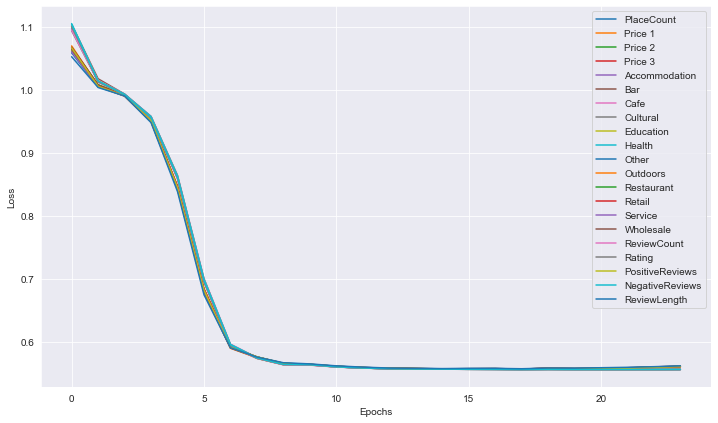

In [9]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

It is seen that the loss curves follow the same pattern with small variations. In the first epoch, the loss curves decrease drastically from different starting points. This decrease is less drastic from epoch 1-3, but then experiences a free fall until epoch 6. After epoch 6, the model keeps learning until epoch 23 where the loss starts to increase. Since the model is trained until the loss starts to increase, we have essentially implemented `EarlyStopping` with a patience of 1 epoch. One could have implemented the actual `EarlyStopping` function from keras with a higher patience, to be certain whether loss would keep increasing after the 23rd epoch.

In [10]:
# saving embeddings in pickle
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/continuous_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Discrete/categorical features <a class="anchor" id="2-bullet"></a>

For the discrete space embeddings model, the continuous features needs to be discretized. As per our mentor's suggestion, the bins/classes of discretized features should be uniformly distributed. Thus, a function is created to ensure this.

In [14]:
# Defining a function for uniform discretizing of the features
# Can only handle features with less than 20% zero values. 

def uniform_Discretization(array): 
    min_bins = 3
    max_bins = 10

    #if input contains zeros, adjust max number of bins
    try:
        calc_bins = np.int32(np.floor(1/(len(np.where(array==0)[0])/len(array))))
        if np.any(array==0) and calc_bins < max_bins and calc_bins-min_bins>0:
            max_bins = calc_bins
    except ZeroDivisionError:
        None

    # find optimal number of bins with least variation in binsize
    minspan = []
    for i in range(min_bins, max_bins+1, 1):
        try:
            Value_count = pd.qcut(array,i).value_counts()
            minspan.append(max(Value_count)-min(Value_count))
        except ValueError:
            minspan.append(1000)
            continue

    bins = np.argmin(minspan)+min_bins
    intervals = np.unique(pd.qcut(array,bins))

    # print number of bins and bin intervals
    print(array.name,'- Bins: ', bins,'--',' '.join(str(x) for x in intervals))

    # uniform discretized bin 
    uniform_vals = pd.qcut(array,bins, labels=False)
    
    return uniform_vals


The discretization function is only applied for features containing less than 20% zero values, which is done to ensure uniform binning is possible. As a result, the number of features is decreased from 21 to 11, whose binning is shown below

In [15]:
# Transforming the dataset to uniform discretized values, for features with less than 20% zeros
import pandas as pd
y_discrete = pd.DataFrame()
for col in y.columns:
    if len(np.where(y[col]==0)[0])/len(y[col])<0.2:
        y_discrete[col] = uniform_Discretization(y[col])
        y_discrete[col] = y_discrete[col].astype("category", copy=False)

PlaceCount - Bins:  3 -- (0.999, 14.667] (14.667, 46.0] (46.0, 669.0]
Price 2 - Bins:  6 -- (-0.001, 3.0] (3.0, 7.0] (7.0, 12.0] (12.0, 22.0] (22.0, 55.167] (55.167, 379.0]
Price 3 - Bins:  3 -- (-0.001, 1.0] (1.0, 6.333] (6.333, 112.0]
Bar - Bins:  4 -- (-0.001, 1.0] (1.0, 3.0] (3.0, 9.0] (9.0, 133.0]
Other - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 91.0]
Restaurant - Bins:  5 -- (-0.001, 1.0] (1.0, 4.0] (4.0, 9.4] (9.4, 25.0] (25.0, 263.0]
ReviewCount - Bins:  5 -- (3.999, 40.8] (40.8, 99.2] (99.2, 225.4] (225.4, 638.2] (638.2, 8699.0]
Rating - Bins:  3 -- (1.5550000000000002, 3.941] (3.941, 4.13] (4.13, 5.0]
PositiveReviews - Bins:  4 -- (0.311, 0.792] (0.792, 0.833] (0.833, 0.864] (0.864, 1.0]
NegativeReviews - Bins:  4 -- (-0.001, 0.136] (0.136, 0.167] (0.167, 0.208] (0.208, 0.688]
ReviewLength - Bins:  3 -- (0.0665, 0.899] (0.899, 1.099] (1.099, 2.218]


Finally, the target data is reshaped from a 480x11 matrix to a list of 11 one-hot encoded matrices of the features. This reshaping is necessary to ensure that the data can be passed into the output layers in the end of the model. Essentially the neural network is a single network doing 11 classification tasks at once with an embedding layer which ties it all together.

In [16]:
# Convert to 
data = []
for c in y_discrete:
    arr = np.asarray(pd.get_dummies(y_discrete[c]).values)
    data.append(arr)

Since there is only 11 features in the discrete data, the max length of the embeddings is set to 8 instead of 15, which was used for the continuous model. The majority of the architecture seen below is similar to the continuous with the exception of softmax activation and cross entropy loss.

In [14]:
def model_builder_discrete(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=3, max_value=8, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer
    dict_losses = {}
    output_acts = []
    for idx in range(len(y_discrete.columns)):
        n_output = y_discrete.iloc[:, idx].nunique()
        output_act = Dense(n_output, activation="softmax", use_bias=True, name="output_layer_cat" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cat' + str(idx)] = 'categorical_crossentropy'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model

The next four code cells is identical to what was used in the continuous model, hence these are not commented. However, an interpretation will be made on the loss curves.

In [15]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_discrete,
                    objective=objective,
                    max_epochs=20,
                    directory="hyperparameter_tuning",
                    project_name="discrete_trials",
                    overwrite=False
)

#tuner.search(X, output_space, callbacks=[stop_early])
tuner.search(X, data)

best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 09s]
loss: 0.005318881012499332

Best loss So Far: 0.003040631767362356
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


In [22]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, data, epochs=300, verbose=0)

train_loss_per_epoch = history.history['loss']

# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1
print("Best epoch:", best_epoch)

Best epoch: 300


In [23]:
# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, data, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/discrete_model")

INFO:tensorflow:Assets written to: models/discrete_model\assets


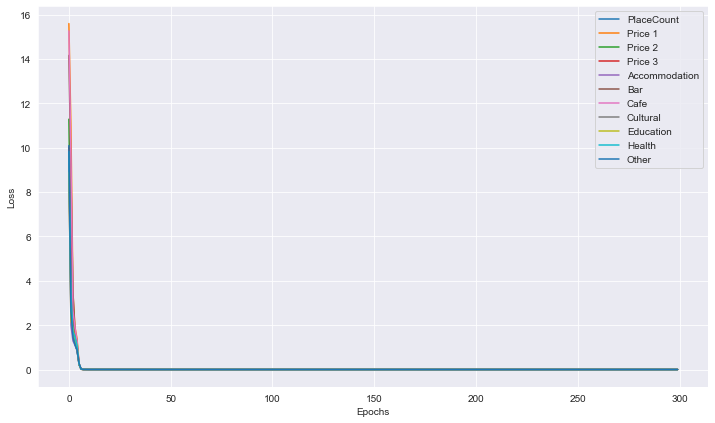

In [24]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

The loss curves for the discrete model decreases severely in the first epoch, whereafter it starts to converge. The model was run for an increasing number of epochs where a loss decrease was found each time. It was decided to stop at 300 epochs in interest of time.

In [28]:
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/discrete_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Model comparison (Continuous vs Discrete/Categorical) <a class="anchor" id="3-bullet"></a>

In this section, it will be decided whether to go forward with the embeddings obtained from the continuous model or the discrete model. Unfortunately, there is no universal way of measuring the performance of embeddings. The performance is all specific to the end-purpose of the embeddings, as indicated in [this stackoverflow answer](https://stackoverflow.com/a/56997733). Since our purpose is to create embeddings, which can identify similar areas across borders from London to NYC and opposite, the following approach was chosen to compare the embedding models: 
1. Perform TSNE and determine if clusters with areas from both cities are present
2. Determine if areas expected to be similar are actually similar

In [64]:
# Load keras models generated from previous two sections
from tensorflow import keras
cont_model = keras.models.load_model("models/continuous_model")
disc_model = keras.models.load_model("models/discrete_model")

The first approach is used to ensure that cross-border grid cell comparisons are feasible. It is considered feasible when grid cells from both cities are mixed and not separated into clusters according to city. TSNE is performed for each embedding model in order to visualize the embeddings in a 2D scatter plot.

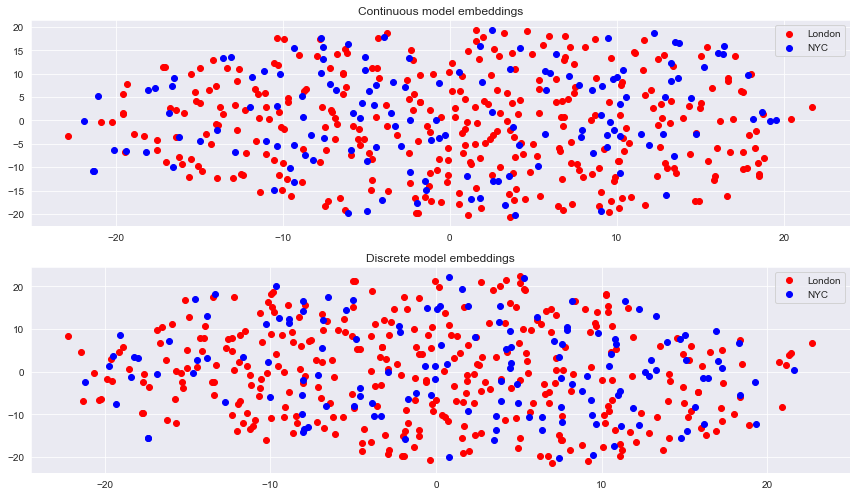

In [65]:
from sklearn.manifold import TSNE
# Apply TSNE to lower dimension of embeddings
cont_embeddings = cont_model.layers[1].get_weights()[0]
disc_embeddings = disc_model.layers[1].get_weights()[0]
X_cont = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(cont_embeddings)
X_disc = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(cont_embeddings)

# Find index of London and NYC grids for scatter plot
fig, ax = plt.subplots(2,1)
london_idx = np.where((df.Grid.str.startswith("L")*1).values==1)
nyc_idx = np.where((df.Grid.str.startswith("N")*1).values==1)

# Create scatter plot for continuous model
ax[0].scatter(X_cont[london_idx, 0], X_cont[london_idx, 1], color="red", label="London")
ax[0].scatter(X_cont[nyc_idx, 0], X_cont[nyc_idx, 1], color="blue", label="NYC")
ax[0].legend()
ax[0].set_title("Continuous model embeddings")

# Create scatter plot for discrete model
ax[1].scatter(X_disc[london_idx, 0], X_disc[london_idx, 1], color="red", label="London")
ax[1].scatter(X_disc[nyc_idx, 0], X_disc[nyc_idx, 1], color="blue", label="NYC")
ax[1].legend()
ax[1].set_title("Discrete model embeddings")
fig.tight_layout()

Luckily, there seems to be no clusters containing only NYC or London areas. The second approach has to be performed to differentiate between the two models. 

The second approach concerns a comparison of the models for areas that are known to be similar across the two cities. These areas have been selected according to Chris Donnan's [blog post](https://chrisdonnan.com/london-new-york-neighborhood-analogies-83549775676) on London/New York neighbourhood analogies. The areas compared are (London mentioned first):
- Mayfair <-> Fifth Avenue
- Chelsea <-> Upper East Side
- Picadilly Circus <-> Times Square
- Shoreditch <-> Lower East Side
- The City <-> Wall Street

The coordinates have been obtained manually through Google Maps. The coordinates are listed as as single point, but the areas are varying in size and can span across multiple grid cells. The next step is to obtain the grid cell for each of these areas. 

In [66]:
cols = ["place", "lat", "lon", "comparison"]
df_test = pd.DataFrame([
    ["Mayfair L", 51.511985026397035, -0.14879873348792902, "C1"],
    ["Fifth Ave NY", 40.774987620333434, -73.96547459831164, "C1"],
    ["Chelsea L", 51.489027977809016, -0.1701367709207771, "C2"],
    ["Upper East Side NY", 40.77042227433877, -73.95413494511916, "C2"],
    ["Picadilly Circus L", 51.51063869930203, -0.13491599824102046, "C3"],
    ["Times Square NY", 40.758689525151674, -73.98528514311366, "C3"],
    ["Shoreditch L", 51.52438917339741, -0.07761514706454309, "C4"],
    ["Lower East Side NY", 40.715576289768045, -73.98573517965326, "C4"],
    ["The City L", 51.51304907945532, -0.09246999957592936, "C5"],
    ["Wall St NY", 40.706556289638975, -74.00878272041244, "C5"]

], columns=cols)

In [67]:
# Use function from data processing notebook
from helperfunctions import get_country_specific_information, get_coordinates
def create_grid(df_input, city):
    if city == "London":
        _, _, _, num = get_country_specific_information()
        prefix = "L"
    else:
        _, _, num, _ = get_country_specific_information()
        prefix = "NY"
    df = df_input.copy()
    df['Grid'] = np.nan
    
    bottomLeft, bottomRight, topLeft, topRight = get_coordinates(city)

    cols = np.linspace(bottomLeft[1], bottomRight[1], num=num)
    rows = np.linspace(bottomLeft[0], topLeft[0], num=num)

    num = 0
    for i in range(len(rows)-1):
        for j in range(len(cols)-1):
            for index,row in df.loc[(df.lon >= cols[j]) & (df.lon <= cols[j+1]) & (df.lat >= rows[i]) & (df.lat <= rows[i+1])].iterrows():
                    df.loc[index, "Grid"] = prefix + str(int(num))

            
            num += 1

    return df

In [68]:
london_df = create_grid(df_test.loc[lambda x: x.place.str.endswith("L")], "London")
ny_df = create_grid(df_test.loc[lambda x: x.place.str.endswith("NY")], "New York")
df_testgrid = pd.concat([london_df, ny_df]).sort_values("comparison")
df_testgrid

,place,lat,lon,comparison,Grid
0,Mayfair L,51.511985,-0.148799,C1,L176
1,Fifth Ave NY,40.774988,-73.965475,C1,NY165
2,Chelsea L,51.489028,-0.170137,C2,L79
3,Upper East Side NY,40.770422,-73.954135,C2,NY168
4,Picadilly Circus L,51.510639,-0.134916,C3,L178
5,Times Square NY,40.758690,-73.985285,C3,NY123
6,Shoreditch L,51.524389,-0.077615,C4,L222
7,Lower East Side NY,40.715576,-73.985735,C4,NY28
8,The City L,51.513049,-0.092470,C5,L182
9,Wall St NY,40.706556,-74.008783,C5,NY4


In [80]:
# Obtain embeddings from each model
df_cont_emb = pd.DataFrame(cont_embeddings, index=df.Grid.values)
df_disc_emb = pd.DataFrame(disc_embeddings, index=df.Grid.values)

To compare embeddings for the given areas, cosine similarity is calculated between areas assumed as comparable. Cosine similarity is chosen due to its bound between -1 and 1, which means that all similarities are on the same scale and makes them comparable. The function below reports the cosine similarity for the area comparisons for each of the two embedding models.

In [141]:
def comparison_func(comparison_num):
    from sklearn.metrics.pairwise import cosine_similarity
    df_c = df_testgrid.loc[lambda x: x.comparison == comparison_num]
    header_text = " <-> ".join(df_c.place.values)
    cont_temp = df_cont_emb.loc[lambda x: x.index.isin(df_c.Grid)]
    disc_temp = df_disc_emb.loc[lambda x: x.index.isin(df_c.Grid)]
    
    print("="*48)
    print(" "*int((48-len(header_text))/2), header_text)
    print("="*48)
    print("Cosine similarity")
    print("Continuous:", cosine_similarity(cont_temp)[0,1])
    print("Discrete:", cosine_similarity(disc_temp)[0,1])

In [142]:
# C1
comparison_func("C1")

            Mayfair L <-> Fifth Ave NY
Cosine similarity
Continuous: -0.31120586
Discrete: 0.6814031


For the first comparison, it is seen that the discrete model performs better than the continuous. This is indicated by the similarity of the discrete model, which is close to 1, as opposed to the continuous model where a negative similarity is calculated. 

In [143]:
# C2
comparison_func("C2")

         Chelsea L <-> Upper East Side NY
Cosine similarity
Continuous: -0.08128221
Discrete: -0.31924143


In this comparison, neither of the models performs as expected, since they both indicate that the two areas are dissimilar. 

In [ ]:
# C3
comparison_func("C3")

      Picadilly Circus L <-> Times Square NY
Cosine similarity
Continuous: 0.5340566
Discrete: 0.04356924


For the third comparison, the continuous model outperforms the discrete model indicated by the much higher similarity value calculated for the continuous model.

In [145]:
# C4
comparison_func("C4")

       Shoreditch L <-> Lower East Side NY
Cosine similarity
Continuous: 0.0052382397
Discrete: -0.603295


Again, both model are not performing as they should, but the discrete model is estimating the areas as more dissimilar than the continuous.

In [146]:
# C5
comparison_func("C5")

            The City L <-> Wall St NY
Cosine similarity
Continuous: -0.15875505
Discrete: -0.36943018


The final comparison is also not very promising for either of our models, since both evaluate the areas as dissimilar.

The model comparison did not provide a clear answer regarding which model to use in the recommender system. The first approach using TSNE indicated that both models were suitable for providing cross border comparisons of area embeddings. In the second approach, two of the five comparisons had similarity values that reflected the expectations. However, it was not unanimous which model was the better of the two. In the remaining three comparisons, no decision could be made regarding a superior model.

Therefore, a decision is made based on the loss curves of the models and suggestions presented by our mentor. The loss curves of the discrete model indicated that it kept learning when increasing the epochs. This indicates that the model is able to obtain better results if trained longer, but this will not be conducted in the interest of time. Furthermore, our mentor highlighted that the discrete model performed better from experience. 

# Conclusion and final remarks <a class="anchor" id="4-bullet"></a>

It has been possible to create embedding vectors for each grid cell successfully, which will be used in the recommender system. The better performing space embeddings model was ambiguous and difficult to identify. Multiple approaches were considered, where none provided a definitive answer. The embeddings from the discrete model did not perform outstanding in the comparisons considered here. However, they will be used for the recommender system, where the recommendations will be validated using stereotypical personas.

The creation of the recommender system and the subsequent analysis can be found in the [Recommender System notebook](./RecommenderSystem.ipynb) which is the next suggested step to learn more about the project.